# Exercise 2.5: Nonstationary Problem

Design and conduct an experiment to demonstrate the difficulties that sample-average methods have for nonstationary problems. Use a modified version of the 10-armed testbed in which all the $q_*(a)$ start out equal and then take independent random walks (say by adding a normally distributed increment with mean zero and standard deviation 0.01 to all the $q_*(a)$ on each step). Prepare plots like Figure 2.2 for an action-value method using sample averages, incrementally computed, and another action-value method using a constant step-size parameter, $\alpha = 0.1$. Use $\epsilon = 0.1$ and longer runs, say of 10,000 steps.

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm  # For progress bar if desired, but standard print works too

In [9]:
def run_bandit_experiment(n_arms=10, n_steps=10000, n_runs=2000, epsilon=0.1, alpha=None):
    """
    Runs a nonstationary bandit experiment vectorized over runs.
    
    Args:
        n_arms: Number of arms (10).
        n_steps: Number of steps per run (10,000).
        n_runs: Number of independent runs (2000).
        epsilon: Probability of random action.
        alpha: Constant step size. If None, use sample averages (1/n).
        
    Returns:
        avg_rewards: Array of shape (n_steps,) containing average reward at each step.
        pct_optimal: Array of shape (n_steps,) containing % optimal action selection at each step.
    """
    # Initialize q_star for all runs (start equal at 0)
    q_star = np.zeros((n_runs, n_arms))
    
    # Initialize estimated values Q
    Q = np.zeros((n_runs, n_arms))
    
    # If using sample averages, track N (count of selections)
    if alpha is None:
        N = np.zeros((n_runs, n_arms))
    
    # Arrays to store history for plotting (averaged over runs later)
    rewards = np.zeros((n_runs, n_steps))
    optimal_actions = np.zeros((n_runs, n_steps))
    
    # Useful indices
    run_indices = np.arange(n_runs)
    
    for step in range(n_steps):
        # --- Nonstationarity ---
        # Random walk: all q*(a) take independent random walks
        q_star += np.random.normal(0, 0.01, (n_runs, n_arms))
        
        # --- Action Selection (Epsilon-Greedy) ---
        # Decisions: True if random action
        explore = np.random.rand(n_runs) < epsilon
        
        # Random actions
        random_actions = np.random.randint(0, n_arms, n_runs)
        
        # Greedy actions
        # np.argmax breaks ties by taking the first one. 
        # To break ties randomly is strictly more correct but computationally heavier.
        # Given the continuous random walk, true ties are extremely rare (float precision).
        greedy_actions = np.argmax(Q, axis=1)
        
        # Choose action
        actions = np.where(explore, random_actions, greedy_actions)
        
        # --- Reward Generation ---
        # R ~ N(q*(A), 1)
        # Get q_star for the chosen actions
        # Advanced indexing: q_star[row, col]
        true_values = q_star[run_indices, actions]
        r_t = np.random.normal(true_values, 1.0)
        
        # Record Reward
        rewards[:, step] = r_t
        
        # Record Optimal Action
        # Optimal action is argmax(q_star)
        best_arms = np.argmax(q_star, axis=1)
        optimal_actions[:, step] = (actions == best_arms).astype(float)
        
        # --- Value Update ---
        if alpha is None:
            # Sample Average: Q_{n+1} = Q_n + 1/n (R - Q_n)
            N[run_indices, actions] += 1
            
            # 1/N step size
            # Get current Q for chosen actions
            old_Q = Q[run_indices, actions]
            step_size = 1.0 / N[run_indices, actions]
            
            # Update
            Q[run_indices, actions] += step_size * (r_t - old_Q)
        else:
            # Constant Step-Size: Q_{n+1} = Q_n + alpha (R - Q_n)
            old_Q = Q[run_indices, actions]
            Q[run_indices, actions] += alpha * (r_t - old_Q)
            
    # Compute averages over runs
    avg_rewards = rewards.mean(axis=0)
    pct_optimal = optimal_actions.mean(axis=0)
    
    return avg_rewards, pct_optimal

In [10]:
# Run Experiments
R_sample, O_sample = run_bandit_experiment(alpha=None, epsilon=0.1)
R_const, O_const = run_bandit_experiment(alpha=0.1, epsilon=0.1)

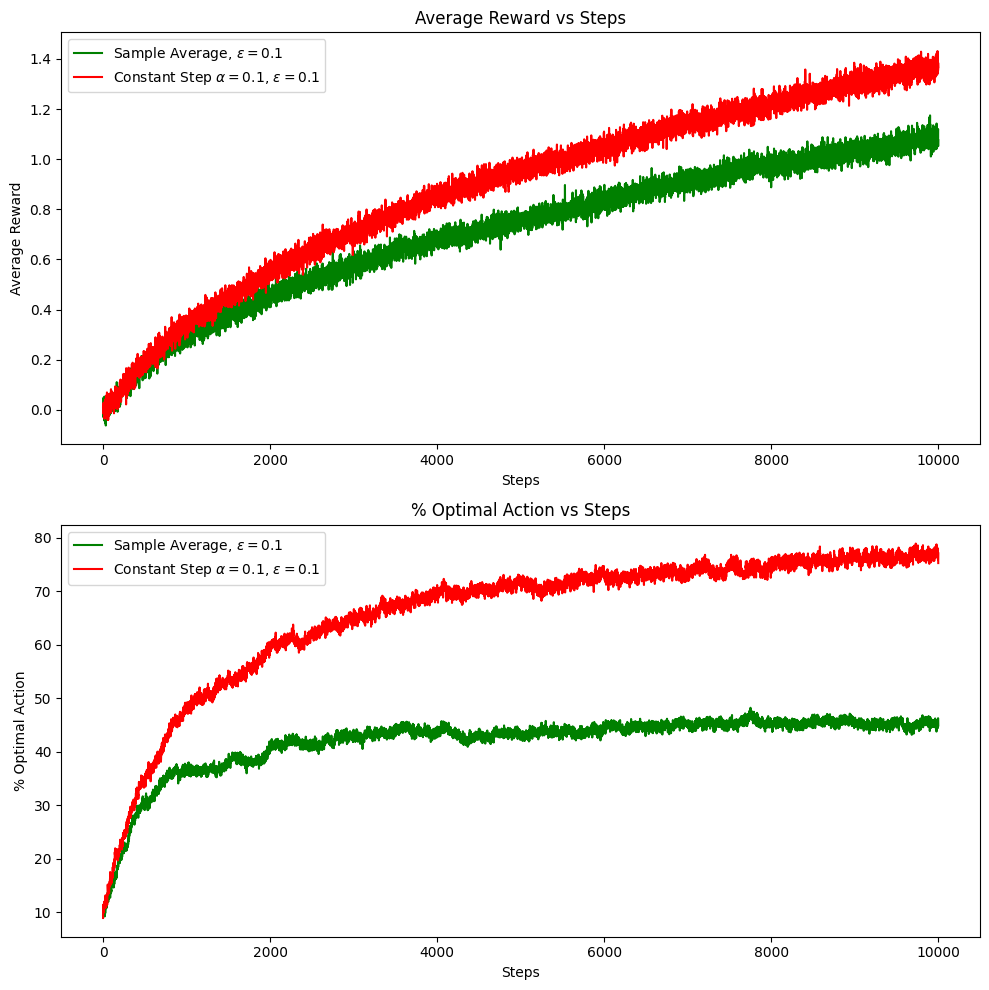

In [11]:
# Plotting Results
plt.figure(figsize=(10, 10))

# Average Reward
plt.subplot(2, 1, 1)
plt.plot(R_sample, label=r'Sample Average, $\epsilon=0.1$', color='green')
plt.plot(R_const, label=r'Constant Step $\alpha=0.1$, $\epsilon=0.1$', color='red')
plt.title('Average Reward vs Steps')
plt.xlabel('Steps')
plt.ylabel('Average Reward')
plt.legend()

# % Optimal Action
plt.subplot(2, 1, 2)
plt.plot(O_sample * 100, label=r'Sample Average, $\epsilon=0.1$', color='green')
plt.plot(O_const * 100, label=r'Constant Step $\alpha=0.1$, $\epsilon=0.1$', color='red')
plt.title('% Optimal Action vs Steps')
plt.xlabel('Steps')
plt.ylabel('% Optimal Action')
plt.legend()

plt.tight_layout()
plt.show()